# Part B1: ArgMax & Softmax - Neural Network Outputs

## Introduction

Welcome to **Part B1** of the Softmax Series!

**StatQuest Style**: "Now let's see how neural networks make predictions... clearly!"

### What We'll Cover

1. The problem with raw neural network outputs (logits)
2. ArgMax - picking the winner (for inference)
3. Why ArgMax fails during training
4. Softmax - the differentiable solution
5. Step-by-step Softmax calculation

### Learning Objectives

By the end of this notebook, you will:
- Understand what logits are
- Know when to use ArgMax vs Softmax
- Calculate Softmax step-by-step
- See why Softmax is essential for training

**Let's dive in!**

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print('✓ Libraries imported')
print('✓ Ready to explore ArgMax and Softmax!')

✓ Libraries imported
✓ Ready to explore ArgMax and Softmax!


---

# Part 1: The Problem - Raw Neural Network Outputs

## What are Logits?

```
┌─────────────────────────────────────────────────────────────┐
│         NEURAL NETWORK OUTPUT PROBLEM                       │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Task: Classify an image as Cat, Dog, or Mouse            │
│                                                             │
│  Neural Network Architecture:                              │
│  ┌──────────┐    ┌──────────┐    ┌──────────┐            │
│  │  Input   │ →  │  Hidden  │ →  │  Output  │            │
│  │  Image   │    │  Layers  │    │  Layer   │            │
│  └──────────┘    └──────────┘    └──────────┘            │
│                                        │                    │
│                                        ↓                    │
│                                   Raw Outputs               │
│                                   (Logits)                  │
│                                                             │
│  Example Output (Logits):                                  │
│  ┌──────────────────────────────────────┐                 │
│  │  Cat:    1.5                          │                 │
│  │  Dog:    0.2                          │                 │
│  │  Mouse: -0.8                          │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Problems with raw logits:                                 │
│  • Can be negative                                         │
│  • Don't sum to 1                                          │
│  • Not interpretable as probabilities                      │
│  • Hard to compare across different models                 │
│                                                             │
│  Question: How do we turn these into a decision?           │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

In [2]:
# Example: Raw neural network outputs (logits)
logits = np.array([1.5, 0.2, -0.8])
classes = ['Cat', 'Dog', 'Mouse']

print('RAW NEURAL NETWORK OUTPUTS (LOGITS)')
print('='*60)
for cls, logit in zip(classes, logits):
    print(f'{cls:<10} {logit:>8.2f}')
print('='*60)
print('\nOBSERVATIONS:')
print(f'  • Sum: {np.sum(logits):.2f} (not 1.0!)')
print(f'  • Contains negative values: {np.any(logits < 0)}')
print(f'  • Highest value: {classes[np.argmax(logits)]} ({np.max(logits):.2f})')
print('\n  → We need a way to convert these to probabilities!')

RAW NEURAL NETWORK OUTPUTS (LOGITS)
Cat            1.50
Dog            0.20
Mouse         -0.80

OBSERVATIONS:
  • Sum: 0.90 (not 1.0!)
  • Contains negative values: True
  • Highest value: Cat (1.50)

  → We need a way to convert these to probabilities!


---

# Part 2: ArgMax - The Simple Solution

## What is ArgMax?

```
┌─────────────────────────────────────────────────────────────┐
│         ARGMAX: PICKING THE WINNER                          │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  ArgMax simply returns the INDEX of the maximum value      │
│                                                             │
│  Input (Logits):                                           │
│  ┌──────────────────────────────────────┐                 │
│  │  Cat:    1.5  ← Maximum!             │                 │
│  │  Dog:    0.2                          │                 │
│  │  Mouse: -0.8                          │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  ArgMax Operation:                                         │
│  ┌──────────────────────────────────────┐                 │
│  │  Find maximum: 1.5                   │                 │
│  │  Return index: 0                     │                 │
│  │  Return class: Cat                   │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Advantages:                                               │
│  ✓ Simple and fast                                         │
│  ✓ Clear decision                                          │
│  ✓ Perfect for inference (deployment)                      │
│                                                             │
│  Disadvantages:                                            │
│  ✗ Not differentiable (flat everywhere)                    │
│  ✗ Can't use for training with gradient descent            │
│  ✗ No probability information                              │
│  ✗ No confidence measure                                   │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

In [3]:
# Implement ArgMax
def argmax_prediction(logits, classes):
    """
    Make prediction using ArgMax.
    
    Args:
        logits: Raw network outputs
        classes: Class names
    
    Returns:
        Predicted class
    """
    idx = np.argmax(logits)
    return classes[idx], idx

# Test ArgMax
predicted_class, predicted_idx = argmax_prediction(logits, classes)

print('ARGMAX PREDICTION')
print('='*60)
print(f'Input logits: {logits}')
print(f'Predicted class: {predicted_class}')
print(f'Predicted index: {predicted_idx}')
print('='*60)
print('\nUSE CASE:')
print('  ArgMax is used during INFERENCE (deployment)')
print('  When you just need the final answer!')

ARGMAX PREDICTION
Input logits: [ 1.5  0.2 -0.8]
Predicted class: Cat
Predicted index: 0

USE CASE:
  ArgMax is used during INFERENCE (deployment)
  When you just need the final answer!


## Why ArgMax Fails During Training

```
┌─────────────────────────────────────────────────────────────┐
│         WHY ARGMAX FAILS FOR TRAINING                       │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Training requires GRADIENTS for backpropagation           │
│                                                             │
│  ArgMax function:                                          │
│  ┌──────────────────────────────────────┐                 │
│  │  f(x) = index of max(x)              │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Derivative of ArgMax:                                     │
│  ┌──────────────────────────────────────┐                 │
│  │  df/dx = 0 (almost everywhere)       │                 │
│  │                                       │                 │
│  │  The function is FLAT!                │                 │
│  │  No gradient to guide learning        │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Visual:                                                   │
│                                                             │
│  ArgMax Output                                             │
│    │                                                        │
│  1 │     ┌─────────────────────                            │
│    │     │                                                  │
│  0 │─────┘                                                  │
│    └──────────────────────────→ Input                      │
│                                                             │
│  Gradient = 0 everywhere except at the jump                │
│  (and undefined at the jump!)                              │
│                                                             │
│  Result: Gradient Descent can't work!                      │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

---

# Part 3: Softmax - The Differentiable Solution

## What is Softmax?

```
┌─────────────────────────────────────────────────────────────┐
│         SOFTMAX: THE TRAINING SOLUTION                      │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Softmax converts logits to probabilities                  │
│                                                             │
│  Properties:                                               │
│  ✓ All outputs between 0 and 1                             │
│  ✓ Outputs sum to 1 (valid probability distribution)       │
│  ✓ Smooth and differentiable                               │
│  ✓ Preserves order (largest logit → largest probability)   │
│                                                             │
│  Formula for output i:                                     │
│  ┌──────────────────────────────────────┐                 │
│  │                                       │                 │
│  │         e^(x_i)                       │                 │
│  │  S_i = ─────────                      │                 │
│  │        Σ e^(x_j)                      │                 │
│  │         j                             │                 │
│  │                                       │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Where:                                                    │
│  • x_i = logit for class i                                 │
│  • e = Euler's number (≈ 2.718)                            │
│  • Σ = sum over all classes                                │
│                                                             │
│  Key Insight:                                              │
│  Exponential (e^x) makes everything positive!              │
│  Division by sum normalizes to probabilities!              │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

---

# Part 4: Softmax Step-by-Step Calculation

```
┌─────────────────────────────────────────────────────────────┐
│         SOFTMAX CALCULATION: STEP-BY-STEP                   │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Input (Logits):                                           │
│  ┌──────────────────────────────────────┐                 │
│  │  Cat:    1.5                          │                 │
│  │  Dog:    0.2                          │                 │
│  │  Mouse: -0.8                          │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Step 1: Exponentiate (e^x)                                │
│  ┌──────────────────────────────────────┐                 │
│  │  e^1.5  = 4.48                        │                 │
│  │  e^0.2  = 1.22                        │                 │
│  │  e^-0.8 = 0.45                        │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Notice: All values are now POSITIVE!                      │
│                                                             │
│  Step 2: Sum all exponentials                              │
│  ┌──────────────────────────────────────┐                 │
│  │  Sum = 4.48 + 1.22 + 0.45 = 6.15     │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Step 3: Normalize (divide by sum)                         │
│  ┌──────────────────────────────────────┐                 │
│  │  Cat:   4.48 / 6.15 = 0.73 (73%)     │                 │
│  │  Dog:   1.22 / 6.15 = 0.20 (20%)     │                 │
│  │  Mouse: 0.45 / 6.15 = 0.07 (7%)      │                 │
│  └──────────────────────────────────────┘                 │
│                                                             │
│  Verification:                                             │
│  • All values between 0 and 1: ✓                           │
│  • Sum = 0.73 + 0.20 + 0.07 = 1.00: ✓                     │
│  • Order preserved (Cat still highest): ✓                  │
│                                                             │
│  Interpretation:                                           │
│  The network is 73% confident it's a Cat!                  │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

In [4]:
# Implement Softmax
def softmax(logits):
    """
    Calculate softmax probabilities.
    
    Args:
        logits: Raw network outputs
    
    Returns:
        Probability distribution
    """
    # Step 1: Exponentiate
    exp_logits = np.exp(logits)
    
    # Step 2: Sum
    sum_exp = np.sum(exp_logits)
    
    # Step 3: Normalize
    probabilities = exp_logits / sum_exp
    
    return probabilities, exp_logits, sum_exp

# Calculate softmax step-by-step
probs, exp_vals, sum_exp = softmax(logits)

print('SOFTMAX CALCULATION: STEP-BY-STEP')
print('='*70)
print('\nInput (Logits):')
for cls, logit in zip(classes, logits):
    print(f'  {cls:<10} {logit:>8.2f}')

print('\nStep 1: Exponentiate (e^x):')
for cls, exp_val in zip(classes, exp_vals):
    print(f'  {cls:<10} {exp_val:>8.3f}')

print(f'\nStep 2: Sum = {sum_exp:.3f}')

print('\nStep 3: Normalize (divide by sum):')
for cls, prob in zip(classes, probs):
    print(f'  {cls:<10} {prob:>8.3f} ({prob*100:>5.1f}%)')

print('\nVerification:')
print(f'  Sum of probabilities: {np.sum(probs):.6f}')
print(f'  All between 0 and 1: {np.all((probs >= 0) & (probs <= 1))}')
print(f'  Highest probability: {classes[np.argmax(probs)]}')
print('='*70)

SOFTMAX CALCULATION: STEP-BY-STEP

Input (Logits):
  Cat            1.50
  Dog            0.20
  Mouse         -0.80

Step 1: Exponentiate (e^x):
  Cat           4.482
  Dog           1.221
  Mouse         0.449

Step 2: Sum = 6.152

Step 3: Normalize (divide by sum):
  Cat           0.728 ( 72.8%)
  Dog           0.199 ( 19.9%)
  Mouse         0.073 (  7.3%)

Verification:
  Sum of probabilities: 1.000000
  All between 0 and 1: True
  Highest probability: Cat


## Visualize the Transformation

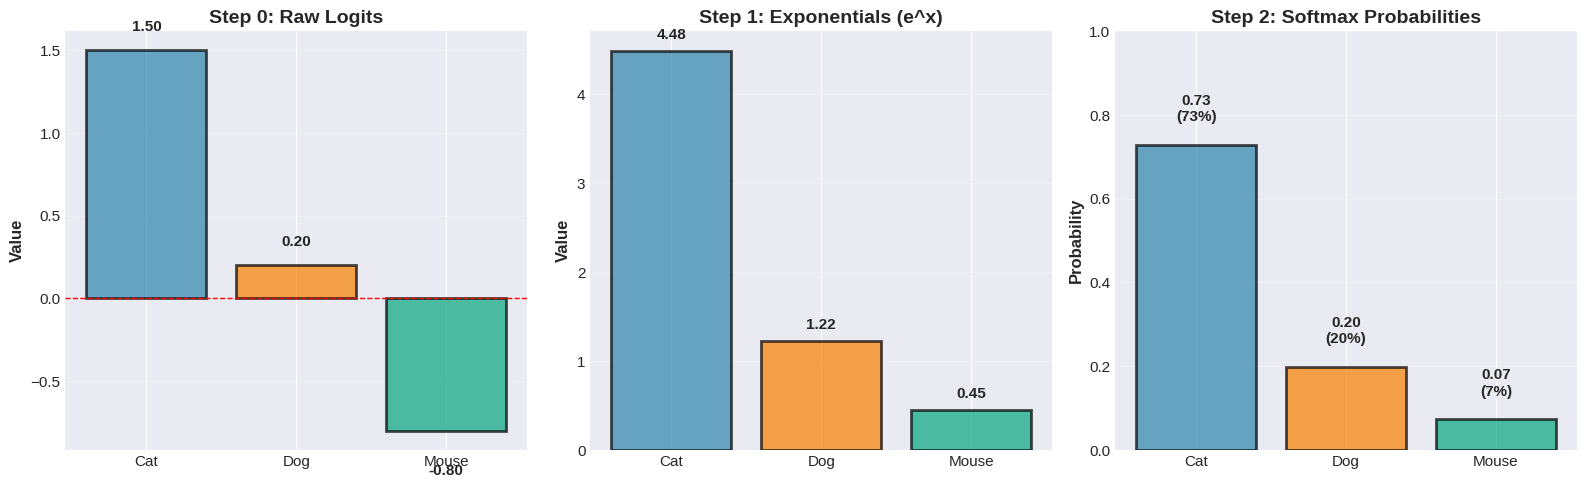


KEY OBSERVATIONS:
  1. Exponential makes all values positive
  2. Normalization creates valid probabilities
  3. Order is preserved (Cat still highest)
  4. Now we have confidence measures!


In [5]:
# Visualize logits vs probabilities
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

x_pos = np.arange(len(classes))
colors = ['#2E86AB', '#F77F00', '#06A77D']

# Plot 1: Logits
bars1 = axes[0].bar(x_pos, logits, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(classes)
axes[0].set_ylabel('Value', fontsize=12, fontweight='bold')
axes[0].set_title('Step 0: Raw Logits', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars1, logits):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.1 if height > 0 else height - 0.2,
                f'{val:.2f}', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=11, fontweight='bold')

# Plot 2: Exponentials
bars2 = axes[1].bar(x_pos, exp_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(classes)
axes[1].set_ylabel('Value', fontsize=12, fontweight='bold')
axes[1].set_title('Step 1: Exponentials (e^x)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, exp_vals):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: Probabilities
bars3 = axes[2].bar(x_pos, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(classes)
axes[2].set_ylabel('Probability', fontsize=12, fontweight='bold')
axes[2].set_title('Step 2: Softmax Probabilities', fontsize=14, fontweight='bold')
axes[2].set_ylim([0, 1.0])
axes[2].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars3, probs):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{val:.2f}\n({val*100:.0f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print('\nKEY OBSERVATIONS:')
print('  1. Exponential makes all values positive')
print('  2. Normalization creates valid probabilities')
print('  3. Order is preserved (Cat still highest)')
print('  4. Now we have confidence measures!')

---

# Summary

## Key Takeaways

1. **Logits**: Raw neural network outputs
   - Can be negative
   - Don't sum to 1
   - Not interpretable as probabilities

2. **ArgMax**: For inference (deployment)
   - Simply picks the maximum
   - Fast and simple
   - NOT differentiable (can't train with it)

3. **Softmax**: For training
   - Converts logits to probabilities
   - Smooth and differentiable
   - Essential for gradient descent

4. **Softmax Formula**: S_i = e^(x_i) / Σ e^(x_j)
   - Step 1: Exponentiate (make positive)
   - Step 2: Sum all exponentials
   - Step 3: Normalize (divide by sum)

## When to Use What?

- **Training**: Use Softmax (need gradients)
- **Inference**: Use ArgMax (just need the answer)

## What's Next?

In **Part B2**, we'll:
- Explore Softmax properties (temperature, numerical stability)
- See how temperature affects the distribution
- Learn the numerical stability trick
- Understand confidence vs uncertainty

**Double Bam!** 💥💥